In [1]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import string
import nltk
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer, RegexpTokenizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, accuracy_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import joblib
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches  # Importar para crear elementos de la leyenda

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel("/content/drive/MyDrive/Data/data_twitter_limpia.xlsx")

In [4]:
#dividiemos la data 80/20
train_data, test_data, train_labels, test_labels = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

In [5]:
train_df = pd.DataFrame({'text': train_data, 'label': train_labels})
#train_df.head(50)

In [6]:
#remplazo cada textos segun su polaridad: neutral: 0, Negativo: -1, Positovo: 1
def create_column_target(data):
    mapping = {0: "Neutral", -1: "Negativo", 1: "Positivo"}
    data['target'] = data['label'].map(mapping)
    return data
train_df = create_column_target(train_df)
train_df = pd.DataFrame(train_df)

In [7]:
def create_countplot(train_df):
  # Configurar el estilo de seaborn
  sns.set(style="whitegrid")

  # Crear un countplot para mostrar porcentajes en el eje y
  plt.figure(figsize=(12, 6))
  sns.countplot(x='target', data=train_df, palette='viridis')

  # Calcular porcentajes y agregar etiquetas
  total = len(train_df['target'])
  for p in plt.gca().patches:
      height = p.get_height()
      plt.text(p.get_x() + p.get_width() / 2., height + 0.01 * total, '{:.1%}'.format(height / total), ha="center")

  plt.title('Distribución de Longitud de Textos según Sentimiento')
  plt.xlabel('Sentimiento')
  plt.ylabel('Frecuencia')
  plt.show()

In [ ]:
create_countplot(train_df)

In [9]:
#Cuenta cuantas veces se repite cada palabra
class TextCounts(BaseEstimator, TransformerMixin):
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x))
        df = pd.DataFrame({'count_words': count_words})
        return df
tc = TextCounts()

In [10]:
#Creo la columna count_words en el dataset traint_df
train_df['count_words'] = tc.fit_transform(train_df.text)

In [11]:
def create_boxplot(train_df):
  # Configurar el estilo de seaborn
  sns.set(style="whitegrid")
  # Crear un boxplot o violin plot
  plt.figure(figsize=(12, 6))
  sns.boxplot(x='target', y='count_words', data=train_df, palette='viridis')

  plt.title('Distribución de Longitud de Textos según Sentimiento')
  plt.xlabel('Sentimiento')
  plt.ylabel('Longitud de Textos')
  plt.show()

<ipython-input-54-89642a19b98d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='count_words', data=train_df, palette='viridis')


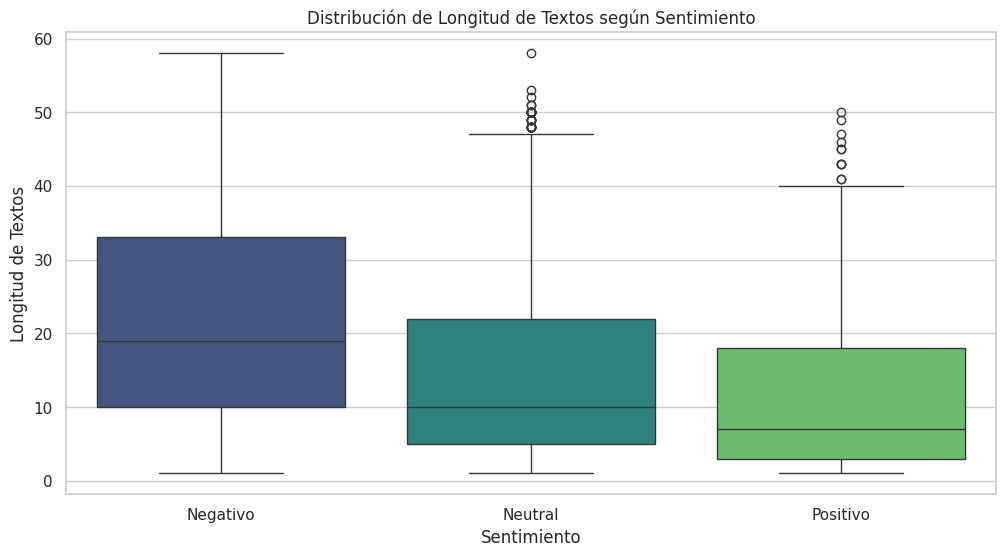

In [ ]:
create_boxplot(train_df)

In [12]:
#Palabras  para eliminar del conjunto de datos
stopwordlist = ['un', 'una','que' ,'unos', 'unas', 'el','y','que', 'la','de', 'los', 'las', 'lo', 'al', 'del', 'a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de', 'desde', 'durante',
                'en', 'entre', 'hacia', 'hasta', 'mediante', 'para', 'por', 'según', 'sin', 'so', 'sobre', 'tras', 'si', 'no', 'ni', 'pero', 'sino', 'más', 'menos',
                'solo', 'sólo', 'también', 'tampoco', 'aunque', 'así', 'debe', 'debería', 'puede', 'podría', 'quizás', 'tal', 'vez', 'como', 'cuando', 'donde',
                'porque', 'siempre', 'nunca', 'jamás', 'igual', 'mismo', 'otro', 'otros', 'otra', 'otras', 'muy', 'mucho', 'poco', 'pocos', 'poca',
                'pocas', 'todo', 'todos', 'toda', 'todas', 'ningún', 'ninguna', 'ningunos', 'ningunas', 'cual', 'cuales', 'qué', 'quien', 'quienes', 'cómo', 'cuánto',
                'cuánta', 'cuántos', 'cuántas', 'qué', 'cuál', 'cuáles', 'éste', 'ésta', 'éstos', 'éstas', 'eso', 'aquello', 'aquí', 'ahí', 'allí', 'cerca', 'lejos',
                'fuera', 'dentro', 'encima', 'debajo', 'abajo', 'arriba', 'medio', 'fuera', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'séptimo',
                'octavo', 'noveno', 'décimo', 'anteayer', 'ayer', 'hoy', 'mañana', 'tarde', 'noche', 'vez', 'veces', 'siempre', 'nunca', 'jamás', 'todavía', 'ya',
                'aun', 'aún', 'quizá', 'tal', 'vez', 'cualquier', 'ninguno', 'todo', 'nadie', 'alguien', 'varios', 'varias', 'mucho', 'poco', 'pocos', 'muchos',
                'muchas', 'bastante', 'demasiado', 'menos', 'más', 'aún', 'incluso', 'solamente', 'únicamente', 'no', 'tampoco', 'sino', 'sí', 'claro', 'por', 'favor',
                'vale', 'hola', 'adiós', 'chao', 'gracias', 'hasta', 'luego', 'si', 'no', 'tal', 'vez', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
                'l', 'm','a', 'actualmente', 'acuerdo', 'adelante', 'además', 'afirmó', 'agregó', 'ahora', 'al', 'algo', 'algún', 'algunas', 'algunos', 'allí', 'alrededor',
                'ambos', 'ante', 'anterior', 'antes', 'apenas', 'aproximadamente', 'aquel', 'aquellas', 'aquellos', 'aqui', 'así', 'aseguró', 'aun', 'aunque', 'ayer',
                'bajo', 'buen', 'buenas', 'buenos', 'cada', 'casi', 'cerca', 'cierta', 'ciertas', 'cierto', 'ciertos', 'como', 'cómo', 'con',
                'conocer', 'considera', 'consideró', 'consigo', 'consigue', 'consiguen', 'contigo', 'contra', 'cosas', 'creo', 'cual', 'cuales', 'cualquier', 'cuando',
                'cuanta', 'cuantas', 'cuanto', 'cuantos', 'cuenta', 'da', 'dado', 'dan', 'dar', 'de', 'debe', 'deben', 'debido', 'decir', 'dejó', 'del', 'delante',
                'demás', 'demasiado', 'dentro', 'deprisa', 'desde', 'después', 'detras', 'dia', 'días', 'dice', 'dicen', 'dicho', 'dieron', 'diferente', 'diferentes',
                'dijeron', 'dijo', 'dio', 'donde', 'dos', 'durante', 'e', 'ejemplo', 'el', 'él', 'ella', 'ellas', 'ello', 'ellos', 'embargo', 'en', 'encuentra',
                'entonces', 'entre', 'era', 'eran', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'está', 'estaba', 'estado', 'estados', 'están', 'estar', 'estas',
                'este', 'esto', 'estos', 'estoy', 'etc', 'ésta', 'éstas', 'este', 'éstos', 'ex', 'excepto', 'existe', 'existen', 'explicó', 'expresó', 'fin', 'fue',
                'fuera', 'fueron', 'gran', 'grandes', 'ha', 'había', 'habían', 'haber', 'habrá', 'hace', 'hacen', 'hacer', 'hacia', 'haciendo', 'hago', 'han', 'hasta',
                'hay', 'haya', 'he', 'hecho', 'hemos', 'hicieron', 'hizo', 'hora', 'horas', 'hoy', 'hubo', 'igual', 'incluso', 'indicó', 'informó', 'junto', 'la',
                'lado', 'las', 'le', 'les', 'llegó', 'lleva', 'llevar', 'lo', 'los', 'luego','q','se','su','tu','o','xq','nos','x','jajaja','te',
                'jajajaja','jajajajajaja', 'nada','jajajajaja','jajajajajajaja','esta','va','pasa', 'biólogo', 'si', 'bien', 'ahora', 'vez', 'dónde', 'ud',
                'sigue', 'debe ser', 'toda', 'van', 'habla', 'mano', 'sra', 'dba', 'asi', 'sabe', 'estan', 'vas', 'ver', 'uds', 'ok', 'mas', 'amigo', 'vamos',
                'ser', 'pm av', 'pues', 'ncr', 'sea', 'son' 'rmp', 'sera','será','parece','nota','tan', 'clos', 'cara', 'der', 'mi', 'estás', 'sacan', 'rojo', 'ven', 'tus', 'cidh', 'ti', '\n']

In [13]:
# Limpio el conjunto de datos
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
  return " ".join([word for word in str(text).split() if word.lower() not in STOPWORDS])
train_df['text'] = train_df['text'].apply(lambda text: cleaning_stopwords(text))

In [14]:
#Tokenizo las fraces
tokenizer = RegexpTokenizer(r'\w+')
train_df['text'] = train_df['text'].apply(tokenizer.tokenize)

In [15]:
# Cambio a su forma base las palabras
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
train_df['text']= train_df['text'].apply(lambda x: stemming_on_text(x))

In [16]:
# Cambio a su forma base las palabras
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
train_df['text'] = train_df['text'].apply(lambda x: lemmatizer_on_text(x))


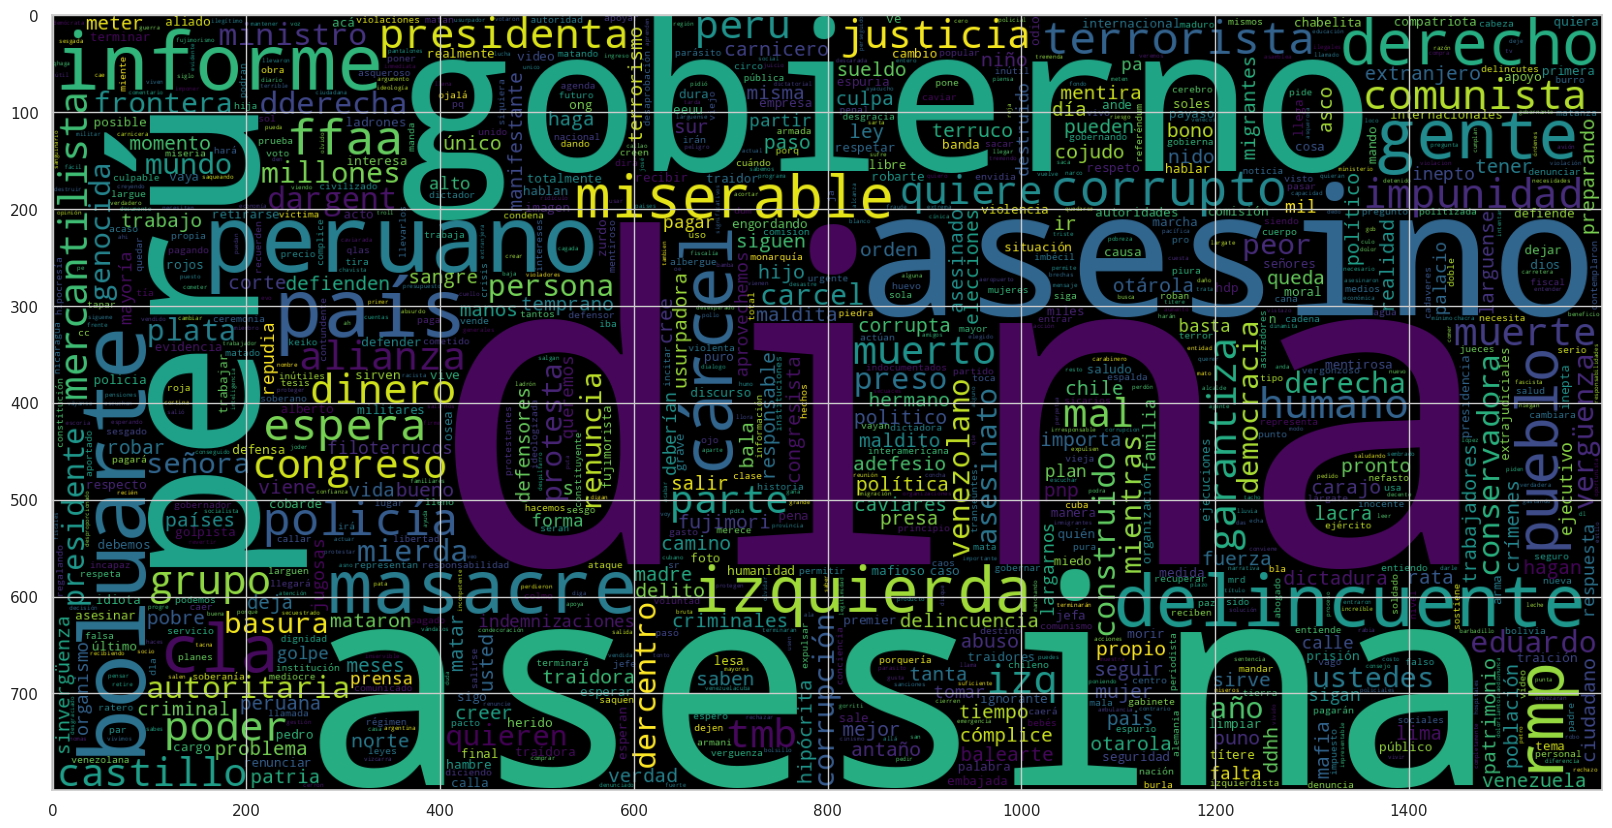

In [17]:
data_negative = train_df.loc[train_df['target'] == 'Negativo', 'text'].tolist()
plt.figure(figsize = (20,20))
wc = WordCloud(stopwords=stopwords.words('spanish'),
               max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(' '.join([' '.join(text) for text in data_negative]))
plt.imshow(wc)

In [18]:
train_df["word"]=train_df.text.str.join(' ')


In [ ]:
cv = CountVectorizer()
bow = cv.fit_transform(train_df["word"])
word_freq = dict(zip(cv.get_feature_names_out(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['Palabra', 'Frecuencia'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="Palabra", y="Frecuencia", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [20]:
from transformers import pipeline
specific_model = pipeline(model="finiteautomata/beto-sentiment-analysis")
#Realizo la prediccion de sentimiento de las palabras con mas frecuencias
text_results = specific_model(word_counter_df["Palabra"].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/481k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
polarity = pd.DataFrame(text_results)
word_counter_df = word_counter_df.join(polarity)
word_delete = ['sus', 'son', 'tiene']
for word in word_delete:
  if word in word_counter_df['Palabra'].values:
    idx_a_eliminar = word_counter_df[word_counter_df['Palabra'] == word].index
    word_counter_df = word_counter_df.drop(idx_a_eliminar)

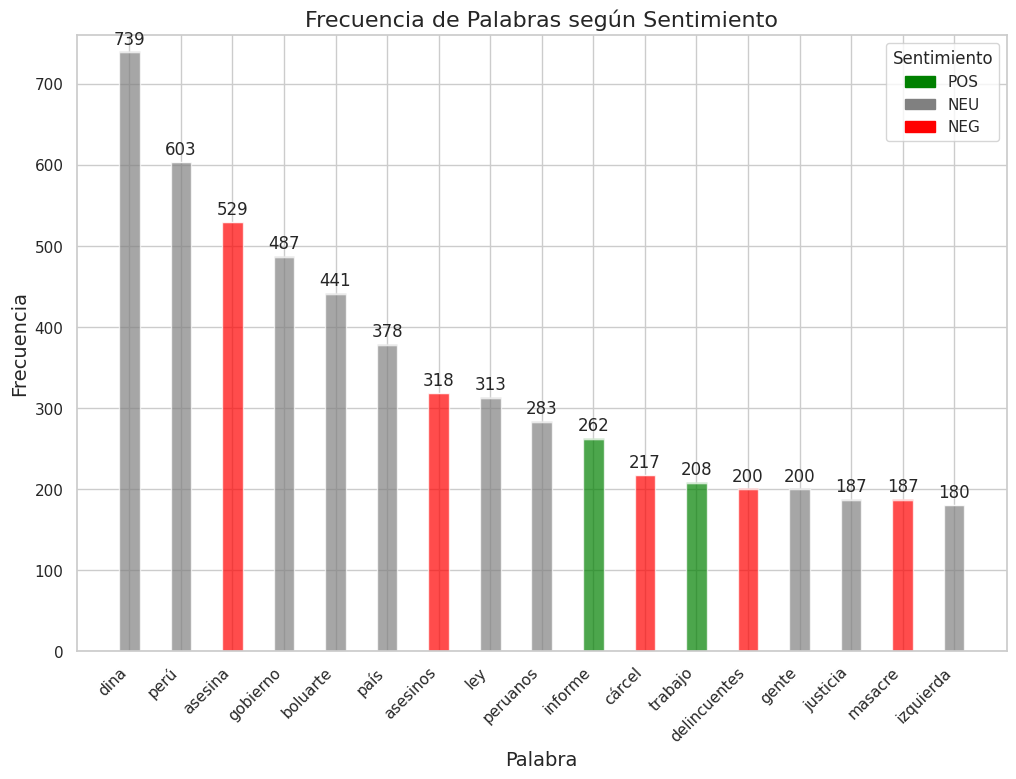

In [22]:
df = pd.DataFrame(word_counter_df)
# Ordenar el DataFrame por la frecuencia en orden descendente
df = df.sort_values(by='Frecuencia', ascending=False)
# Asignar colores según el sentimiento
colors = {'POS': 'green', 'NEU': 'gray', 'NEG': 'red'}

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))

# Plotear las barras de frecuencia
bars_freq = plt.bar(df['Palabra'], df['Frecuencia'], color=df['label'].map(colors), alpha=0.7, label='Frecuencia', width=0.4)

# Ajustar la altura de las barras según la frecuencia
for bar, freq in zip(bars_freq, df['Frecuencia']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, freq, ha='center', va='bottom')

# Plotear las barras de score
bars_score = plt.bar(df['Palabra'], df['score'], color=df['label'].map(colors), alpha=0.5, label='Score', width=0.4, bottom=df['Frecuencia'])
# Agregar etiquetas y leyenda
plt.xlabel('Palabra', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.title('Frecuencia de Palabras según Sentimiento', fontsize=16)
# Crear elementos de la leyenda
legend_elements = [mpatches.Patch(color=color, label=sentimiento) for sentimiento, color in colors.items()]

# Añadir leyenda personalizada
plt.legend(handles=legend_elements, title='Sentimiento')

# Establecer límite en el eje y
plt.ylim(0, max(df['Frecuencia'] + df['score']) + 20)

# Mostrar el gráfico
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas en el eje x para mayor legibilidad
plt.show()

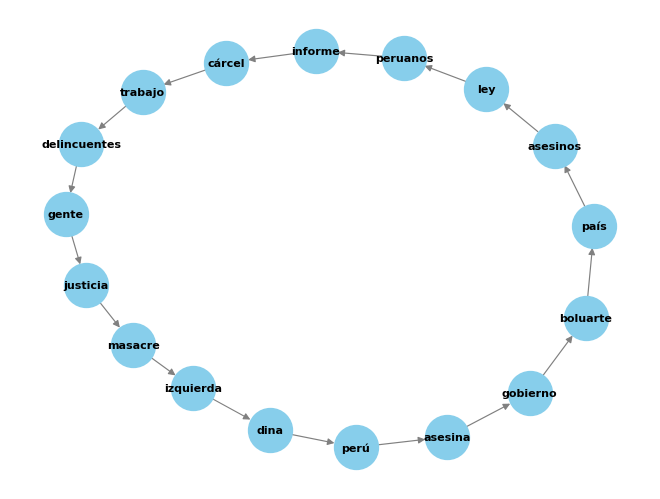

In [23]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
textos = word_counter_df["Palabra"]
import networkx as nx
import matplotlib.pyplot as plt
textos_array = []
for texto in word_counter_df["Palabra"]:
    textos_array.append(texto)
G = nx.DiGraph()

palabras = [palabra.lower() for texto in textos for palabra in textos_array]

# Agregar nodos y aristas al grafo
for i in range(len(palabras) - 1):
    palabra_actual = palabras[i]
    palabra_siguiente = palabras[i + 1]
    if not G.has_edge(palabra_actual, palabra_siguiente):
        G.add_edge(palabra_actual, palabra_siguiente, weight=1)
    else:
        G[palabra_actual][palabra_siguiente]['weight'] += 1

# Dibujar el grafo
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold', edge_color='gray', width=[0.05 * G[u][v]['weight'] for u, v in G.edges()])

# Mostrar el gráfico
plt.show()


In [24]:
# Crear vectores TF-IDF para representar los textos
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
train_vectors = tfidf_vectorizer.fit_transform(train_data)
test_vectors = tfidf_vectorizer.transform(test_data)

In [25]:
# Definir modelos base
base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('nb', BernoulliNB()),
    ('nb_multinomial', MultinomialNB()),
    ('svm', SVC(kernel='linear', probability=True)),
    ('decision_tree', DecisionTreeClassifier()),
    ('random_forest', RandomForestClassifier()),
    ('knn', KNeighborsClassifier())
]

In [26]:
# Definir clasificador final
final_classifier = LogisticRegression()

In [27]:
# Crear el ensamble de clasificadores
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=final_classifier,
    stack_method='auto',
    n_jobs=-1  # Ajustar según el número de núcleos de tu CPU
)

In [28]:
def evaluate_auc_curva(model, test_vectors, test_labels):
# Obtener las predicciones
  y_pred = model.predict(test_vectors)

  # Calcular el reporte de clasificación
  #print("Reporte de Clasificación:\n", classification_report(test_labels, y_pred))
  # Binarizar las etiquetas para la curva ROC
  test_labels_bin = label_binarize(test_labels, classes=[-1, 0, 1])
  # Obtener las probabilidades predichas para el conjunto de prueba
  y_score = model.predict_proba(test_vectors)
  # Calcular la curva ROC para cada clase
  plt.figure(figsize=(8, 6))

  for i in range(len(model.classes_)):
      fpr, tpr, _ = roc_curve(test_labels_bin[:, i], y_score[:, i])
      roc_auc = auc(fpr, tpr)
      # Graficar la curva ROC para cada clase
      modelo = "Negativo" if model.classes_[i] == -1 else ("Neutral" if model.classes_[i] == 0 else "Positivo")
      plt.plot(fpr, tpr, lw=2, label='Curva ROC (AUC = %0.2f) para clase %s' % (roc_auc, modelo))
      # Agregar título y leyenda para cada clase
      plt.title(f'Curva ROC para Análisis de Sentimientos (Clasificación {modelo})')
      plt.xlabel('Tasa de Falsos Positivos')
      plt.ylabel('Tasa de Verdaderos Positivos')
      plt.legend(loc="lower right")
      # Mostrar el gráfico actual antes de pasar a la siguiente clase
      plt.show()

  # Mostrar la línea diagonal de referencia en el último gráfico
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])

  # Mostrar el último gráfico
  plt.show()

In [29]:
# Definir una función de formato para agregar el símbolo de porcentaje
def evaluate_matriz_confucion_tree_class_sin_porcentaje(model, test_vectors, test_labels):
  y_pred = model.predict(test_vectors)
  # Print the classification report
  print(classification_report(test_labels, y_pred))

  # Compute and plot the confusion matrix
  cf_matrix = confusion_matrix(test_labels, y_pred)

  # Define categories for confusion matrix
  categories = ['Negative', 'Neutral', 'Positive']

  # Plot the confusion matrix using seaborn
  sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g',
              xticklabels=categories, yticklabels=categories)

  # Set labels and title
  plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
  plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
  plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)

  # Show the plot
  plt.show()

In [30]:
# Definir una función de formato para agregar el símbolo de porcentaje
def evaluate_matriz_confucion_tree_class_con_porcentaje(model, test_vectors, test_labels):
  y_pred = model.predict(test_vectors)
  num_classes = len(np.unique(np.concatenate((test_labels, y_pred))))
  # Crear y visualizar la matriz de confusión con porcentajes
  cm = confusion_matrix(test_labels, y_pred)

  # Convertir a porcentajes
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
  #print(cm_percentage)
  # Utilizar seaborn para hacer la matriz de confusión más visual
  plt.figure(figsize=(10, 8))
  category_letters = ['Negativo', 'Neutral', 'Positivo']
  # formatter = FuncFormatter(percentage_format)
  sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=category_letters, yticklabels=category_letters)
  for i in range(len(model.classes_)):
      for j in range(len(model.classes_)):
          plt.text(j + 0.5, i + 0.7, f'Falso Neg={cm[i, j] if i == j else 0}', ha='center', va='center', fontsize=8, color='green')
          plt.text(j + 0.5, i + 0.3, f'Falso Pos={cm[i, j] - cm[j, j] if i != j else cm[i, j]}', ha='center', va='center', fontsize=8, color='red')
  plt.xlabel('Predicciones')
  plt.ylabel('Valores Verdaderos')
  plt.title('Matriz de Confusión (Porcentajes con Falso Negativo y Falso Positivo)')
  plt.show()

In [31]:
from sklearn.metrics import precision_recall_curve, f1_score
def evaluate_f1_scores(model, test_vectors, test_labels, classes):
    y_pred_prob = model.predict_proba(test_vectors)
    # Inicializar listas para almacenar las métricas por clase
    precisions = []
    recalls = []
    f1_scores = []

    # Calcular las métricas para cada clase
    for class_index, class_name in enumerate(classes):
        y_true_class = (test_labels == class_name).astype(int)
        y_pred_class = y_pred_prob[:, class_index]

        precision, recall, thresholds = precision_recall_curve(y_true_class, y_pred_class)
        f1_scores_class = [f1_score(y_true_class, y_pred_class >= threshold) for threshold in thresholds]

        # Almacenar las métricas para la clase actual
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_scores_class)

        # Plotear la curva Precision-Recall para cada clase
        plt.figure(figsize=(10, 6))
        plt.plot(recall, precision, label=f'Clase { "Negativo" if class_name == -1 else ("Positivo" if class_name == 1 else "Neutro")}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Curva Precision-Recall para Clases Múltiples')
        plt.legend()

    # Mostrar el gráfico
    plt.show()

    # Plotear la curva F1-score para cada clase
    plt.figure(figsize=(10, 6))
    for class_index, class_name in enumerate(classes):
        plt.plot(thresholds, f1_scores[class_index], label=f'F1-score - Clase { "Negativo" if class_name == -1 else ("Positivo" if class_name == 1 else "Neutro")}')

    plt.xlabel('Umbral de Decisión')
    plt.ylabel('F1-score')
    plt.title('Rendimiento del F1-score en Diferentes Umbrales para Clases Múltiples')
    plt.legend()
    plt.show()

In [32]:
# Entrenar metodo stacking
stacking_model.fit(train_vectors, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('nb', BernoulliNB()),
                               ('nb_multinomial', MultinomialNB()),
                               ('svm', SVC(kernel='linear', probability=True)),
                               ('decision_tree', DecisionTreeClassifier()),
                               ('random_forest', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [33]:
X_train = train_vectors # Data de entrenamiento
y_train = train_labels # Data de prueba

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = cross_val_score(stacking_model, X_train, y_train, cv=10, scoring='accuracy')


In [35]:
print(f'Accuracy promedio: {accuracy.mean()}')

Accuracy promedio: 0.7587243356557124


In [ ]:
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import cross_val_predict, cross_val_score
# Utiliza cross_val_predict para obtener las predicciones en cada iteración
predicted = cross_val_predict(stacking_model, X_train, y_train, cv=10)


In [ ]:
precision_per_fold = cross_val_score(stacking_model, X_train, y_train, cv=10, scoring=make_scorer(precision_score, average='micro'), n_jobs=-1)

In [38]:
# Calcula la precisión promedio
average_precision = precision_score(y_train, predicted, average='micro')

In [39]:
print(f'Precisión promedio: {average_precision}')

Precisión promedio: 0.762501888502795


In [ ]:
from sklearn.metrics import recall_score, make_scorer
recall_multi = make_scorer(recall_score, average='weighted')
recall = cross_val_score(stacking_model, X_train, y_train, cv=10, scoring=recall_multi)


In [41]:
print(f'Recall promedio: {recall.mean()}')

Recall promedio: 0.7614447120768222


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
y_pred = cross_val_predict(stacking_model, X_train, y_train, cv=10)
f1 = f1_score(y_train, y_pred, average='weighted')

In [45]:
print(f'F1-Score promedio: {f1}')

F1-Score promedio: 0.7475506496721859


              precision    recall  f1-score   support

          -1       0.81      0.92      0.86      1089
           0       0.72      0.56      0.63       514
           1       0.81      0.25      0.38        52

    accuracy                           0.79      1655
   macro avg       0.78      0.58      0.63      1655
weighted avg       0.78      0.79      0.77      1655



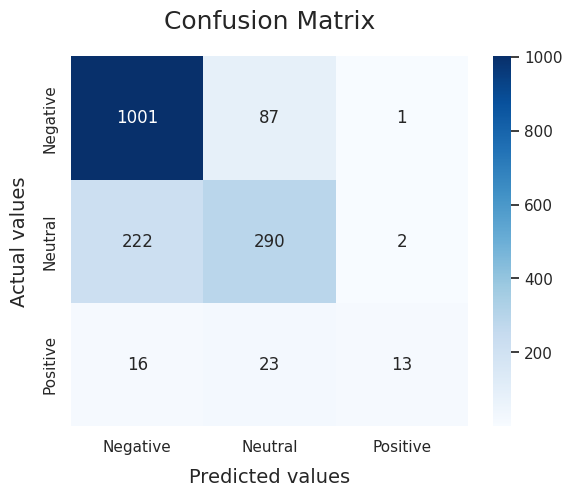

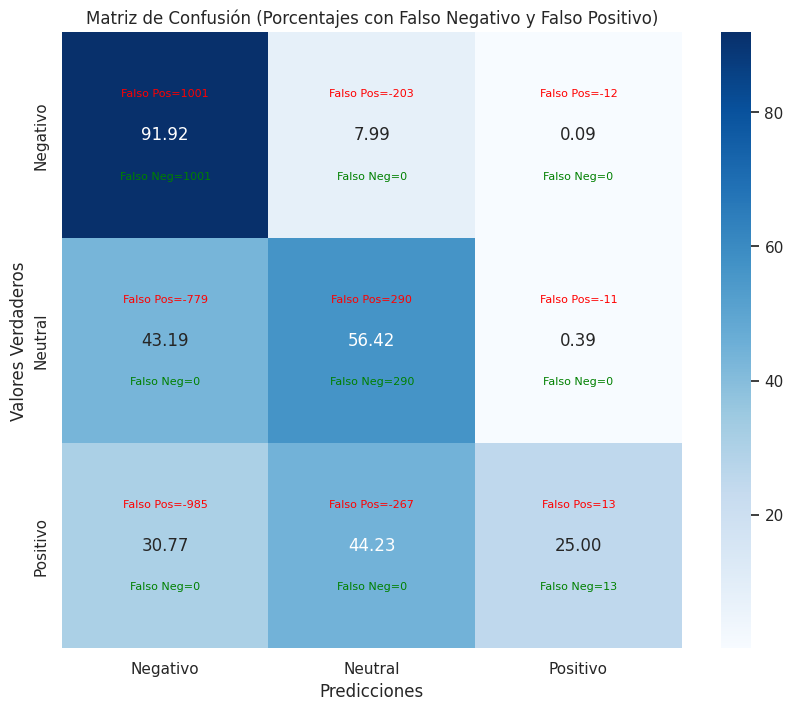

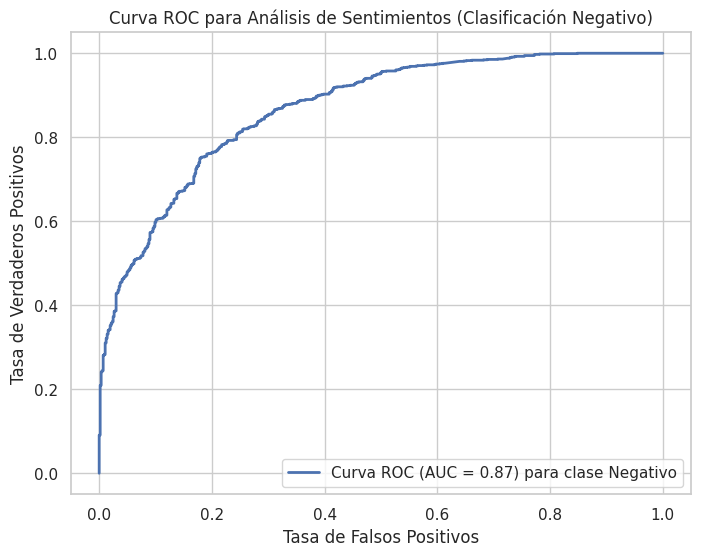

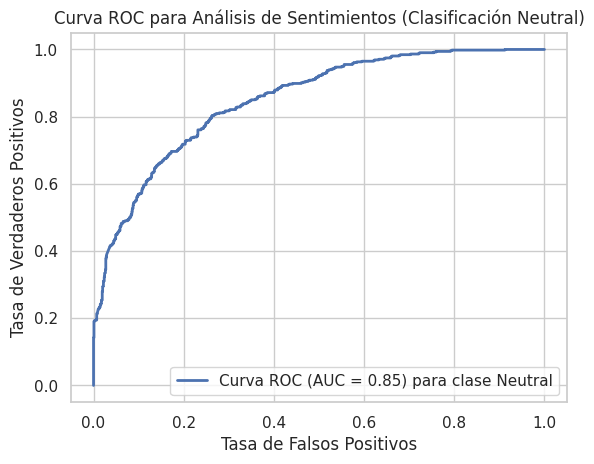

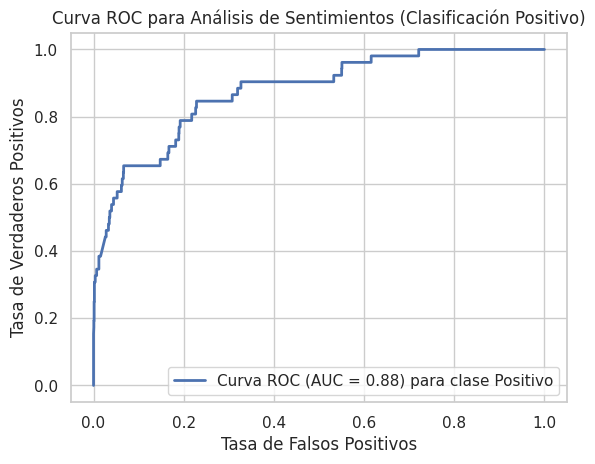

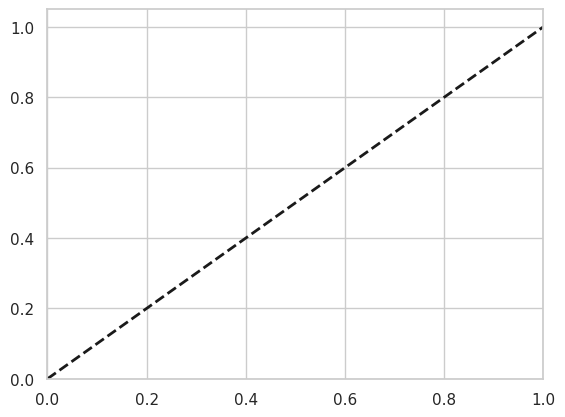

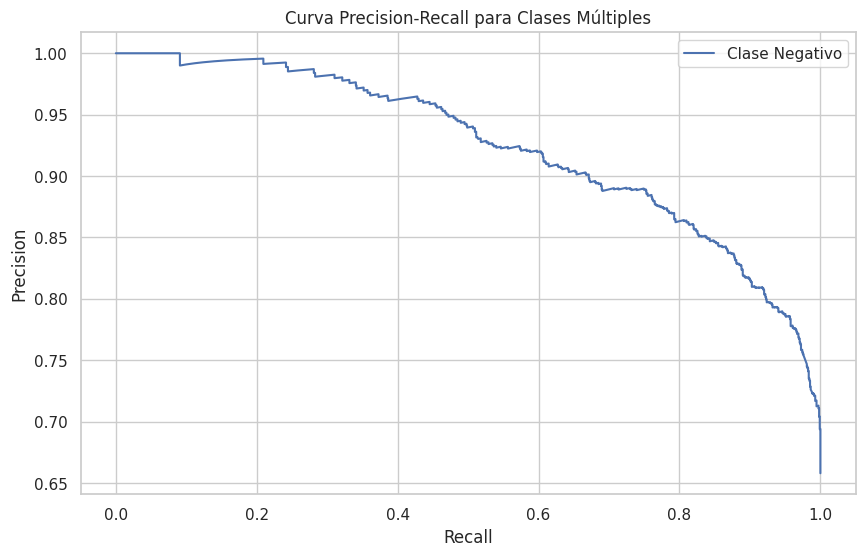

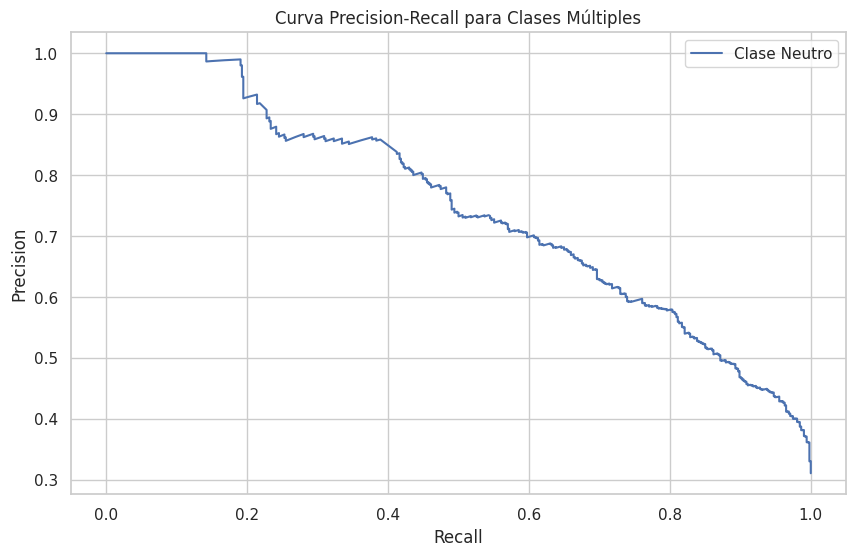

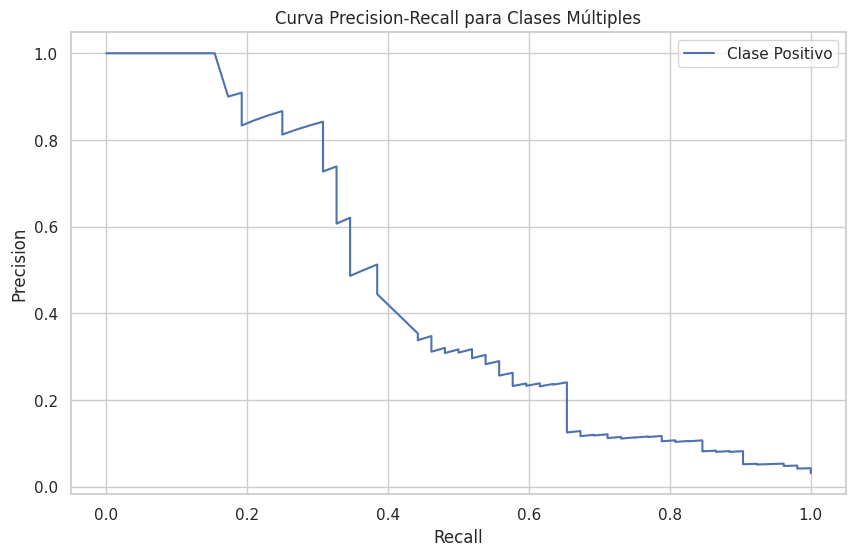

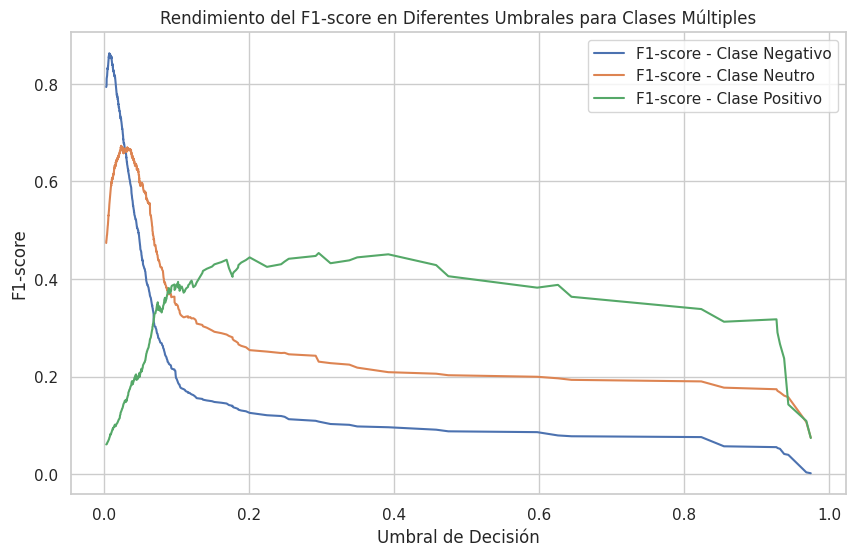

In [46]:
evaluate_matriz_confucion_tree_class_sin_porcentaje(stacking_model, test_vectors, test_labels)
# evaluate_matriz_confucion_tree_class_con_porcentaje(stacking_model, test_vectors, test_labels)
evaluate_auc_curva(stacking_model, test_vectors, test_labels)
classes = [-1, 0, 1];
evaluate_f1_scores(stacking_model, test_vectors, test_labels, classes)

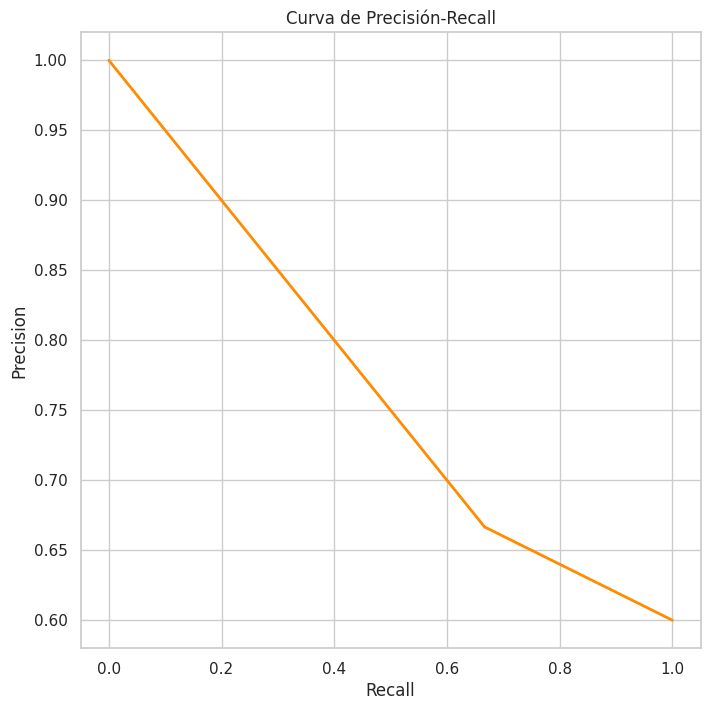

In [47]:
from sklearn.metrics import precision_recall_curve
y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 1]
y_pred = [1, 0, 1, 0, 1, 1, 0, 1, 1, 0]
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisión-Recall')
plt.show()

In [48]:
# Mover el archivo desde Google Drive al entorno de Colab
!cp "/content/drive/MyDrive/modelosIndividuales/model_multinomial_nb.pkl" .

In [49]:
modelo_naive_bayes = joblib.load('model_multinomial_nb.pkl')

In [50]:
# Mover el archivo desde Google Drive al entorno de Colab
!cp "/content/drive/MyDrive/modelosIndividuales/model_regresion_logist.pkl" .

In [51]:
def tokenize_and_preprocess(text):
  return text

In [52]:
modelo_regresion_logistica = joblib.load('model_regresion_logist.pkl')

In [53]:
# Realizar predicciones en el conjunto de prueba con el ensamble
predictions = stacking_model.predict(test_vectors)
predictions_nayve_bayes = modelo_naive_bayes.predict(test_data)
predictions_regresion_logist = modelo_regresion_logistica.predict(test_data)
#predictions = boosting_model.predict(test_vectors)

In [54]:
# Crear un gráfico de barras para mostrar la precisión
def draw_accuracy(accuracy, des_model):
  plt.figure(figsize=(8, 6))
  plt.plot([0, 1], [accuracy, accuracy], marker='o', linestyle='-', color='b', label=f'Precisiòn del Modelo')
  plt.title(f'Precisión del Modelo {des_model}')
  plt.xlabel(f'Modelo {des_model}')
  plt.ylabel('Precisión')
  plt.legend()
  plt.show()

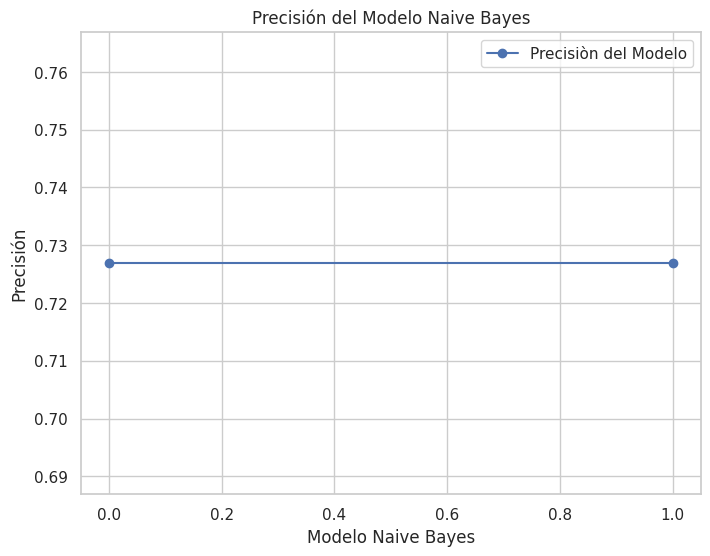

Precisión del modelo Naive Bayes: 0.7268882175226586


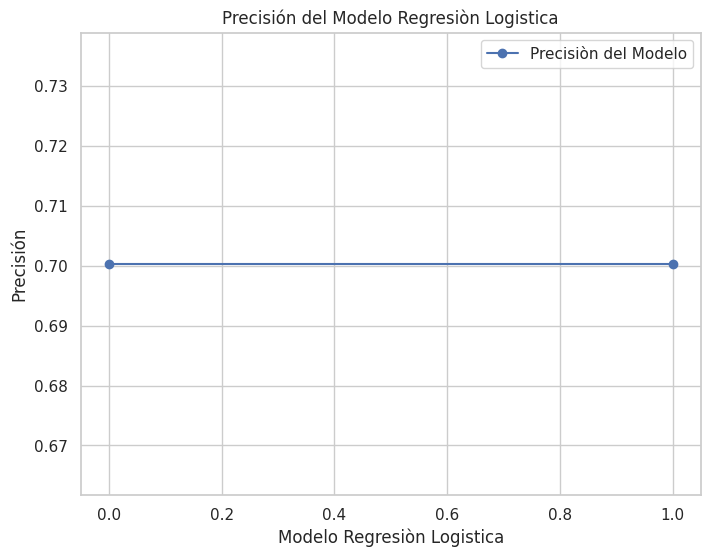

Precisión del modelo Logist Regresion: 0.7003021148036254


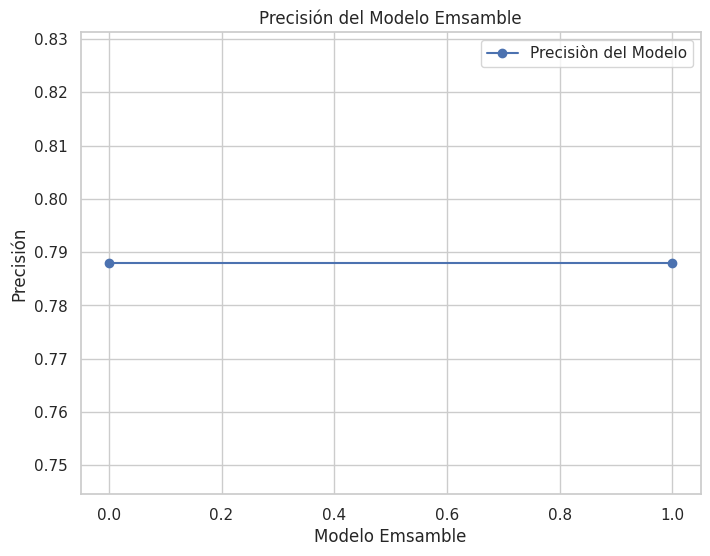

Precisión del ensamble: 0.7879154078549849


In [55]:
# Medir la precisión del ensamble
accuracy_naive_bayes = accuracy_score(test_labels, predictions_nayve_bayes)
draw_accuracy(accuracy_naive_bayes, 'Naive Bayes')
print(f'Precisión del modelo Naive Bayes: {accuracy_naive_bayes}')
accuracy_logist_regresion = accuracy_score(test_labels, predictions_regresion_logist)
draw_accuracy(accuracy_logist_regresion, 'Regresiòn Logistica')
print(f'Precisión del modelo Logist Regresion: {accuracy_logist_regresion}')
accuracy_emsemble = accuracy_score(test_labels, predictions)
draw_accuracy(accuracy_emsemble, 'Emsamble')
print(f'Precisión del ensamble: {accuracy_emsemble}')

In [56]:
# Guardar el ensamble en un archivo
joblib.dump(stacking_model, 'stacking_model.pkl')

['stacking_model.pkl']